In [4]:
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import statistics as stats
import matplotlib as mp
SIZE, BATCH_SIZE = 224, 10
data_dir = "archive/frames/"
img_height = 480
img_width = 640

In [5]:
labels = np.load("archive/labels.npy").flatten()

In [6]:
def display_img_w_pred(model, ds,batch, img):
        pred = [x[0] for x in model.predict(ds[batch][0])][img]
        print(f"Prediction: {pred} Actual: {ds[batch][1][img]}")
        plt.imshow(ds[batch][0][img].astype("uint8"))

In [7]:
def make_ds(dir,labels, val, batch_size):
    ret = tf.keras.utils.image_dataset_from_directory(
  dir,
  # labels=list([classify(x) for x in labels]),
  labels=list(labels),
  validation_split=0.2,
  subset="validation" if val else "training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
    return ret

In [8]:
def display_losses(history, epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    error = history.history['mean_squared_logarithmic_error']
    val_error = history.history['val_mean_squared_logarithmic_error']

    epochs_range = range(epochs)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, error, label='Training Error')
    plt.plot(epochs_range, val_error, label='Validation Error')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Error')
    plt.show()

In [10]:
train_ds = make_ds(data_dir,labels,False, BATCH_SIZE)
val_ds = make_ds(data_dir,labels,True, BATCH_SIZE)

Found 2000 files belonging to 39 classes.
Using 1600 files for training.
Found 2000 files belonging to 39 classes.
Using 400 files for validation.


In [74]:
ds = list(train_ds.as_numpy_iterator())
mall_ds = list(mall_train_ds.as_numpy_iterator())

2023-10-28 16:36:43.724658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-10-28 16:36:43.725002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1600]
	 [[{{node Placeholder/_0}}]]
2023-10-28 16:36:46.134499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1600]

In [8]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [9]:
rescaling_layer = tf.keras.layers.Rescaling(1./255)

In [31]:
model = tf.keras.Sequential([
    rescaling_layer,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(2,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(8,3,activation="tanh"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16,3,activation="sigmoid"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(1, activation="linear"),
])

In [32]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()])

In [41]:
epochs = 5
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/5
160/160 [==============================] - 54s 335ms/step - loss: 12.2106 - mean_squared_logarithmic_error: 0.0127 - val_loss: 10.2006 - val_mean_squared_logarithmic_error: 0.0115
Epoch 2/5
160/160 [==============================] - 53s 330ms/step - loss: 10.9676 - mean_squared_logarithmic_error: 0.0112 - val_loss: 10.7184 - val_mean_squared_logarithmic_error: 0.0120
Epoch 3/5
160/160 [==============================] - 53s 329ms/step - loss: 10.1262 - mean_squared_logarithmic_error: 0.0103 - val_loss: 10.9731 - val_mean_squared_logarithmic_error: 0.0097
Epoch 4/5
160/160 [==============================] - 54s 336ms/step - loss: 9.3667 - mean_squared_logarithmic_error: 0.0100 - val_loss: 7.3304 - val_mean_squared_logarithmic_error: 0.0077
Epoch 5/5
160/160 [==============================] - 53s 329ms/step - loss: 7.1789 - mean_squared_logarithmic_error: 0.0075 - val_loss: 6.9511 - val_mean_squared_logarithmic_error: 0.0073


In [93]:
def display_preds(ds, nums):
    for x in range(nums):
        pred = [x[0] for x in model.predict(ds[x][0])]
        print(f"Dif: {(pred-ds[x][1])/(ds[x][1])}")

In [64]:
display_preds(ds,5)

1/1 [==============================] - 0s 96ms/step
Dif: [-0.33430481  2.36016846  0.11671448  0.62103844 -2.44394302  4.04862022
 -2.7566185   1.83287811  0.25297928  3.09491539]
1/1 [==============================] - 0s 89ms/step
Dif: [-2.39982605 -1.67819405 -3.5215168  -1.63166809 -1.94730949 -0.22132683
 -2.27661896 -3.4882946  -1.40279579 -0.10485268]
1/1 [==============================] - 0s 94ms/step
Dif: [-1.36032867 -0.91488266 -5.26460838  0.24736023  1.430336    3.2450695
  0.76852798 -1.07170868 -0.07946205 -3.69948769]
1/1 [==============================] - 0s 87ms/step
Dif: [-0.0122757  -5.55007172 -0.94718742 -3.65684509  0.70761871  0.09664726
  0.7029686  -3.09774017 -2.89690971  0.31949043]
1/1 [==============================] - 0s 85ms/step
Dif: [-1.51161575 -0.8720417   1.72916794 -2.16640854 -0.97911453  0.83428955
 -2.56647301 -2.11150169 -1.36940765 -1.00028038]


In [43]:
model.evaluate(val_ds)

40/40 [==============================] - 3s 71ms/step - loss: 6.9511 - mean_squared_logarithmic_error: 0.0073


[6.951121807098389, 0.007265470456331968]

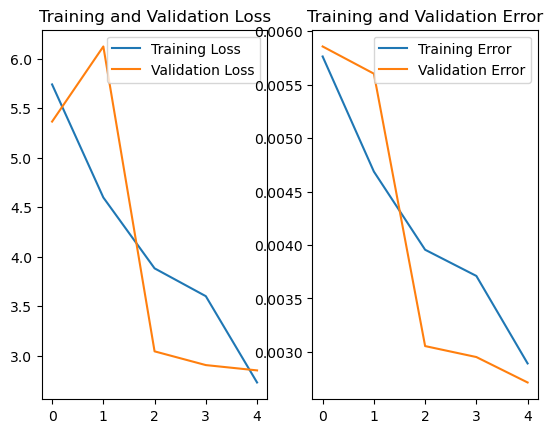

In [97]:
display_losses(history,epochs)

In [120]:
sb_train_ds = make_ds(data_dir,labels,False, 5)
sb_val_ds = make_ds(data_dir,labels,True, 5)

Found 2000 files belonging to 39 classes.
Using 1600 files for training.
Found 2000 files belonging to 39 classes.
Using 400 files for validation.


In [121]:
sb_history = model.fit(sb_train_ds,validation_data=mall_val_ds,epochs=epochs)

Epoch 1/5


2023-10-28 17:58:39.854474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-10-28 17:58:39.855220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]


320/320 [==============================] - 64s 200ms/step - loss: 4.7940 - mean_squared_logarithmic_error: 0.0049 - val_loss: 4.4607 - val_mean_squared_logarithmic_error: 0.0045
Epoch 2/5
320/320 [==============================] - 63s 196ms/step - loss: 3.5102 - mean_squared_logarithmic_error: 0.0035 - val_loss: 2.9522 - val_mean_squared_logarithmic_error: 0.0032
Epoch 3/5
320/320 [==============================] - 63s 197ms/step - loss: 3.2183 - mean_squared_logarithmic_error: 0.0034 - val_loss: 2.3939 - val_mean_squared_logarithmic_error: 0.0025
Epoch 4/5
320/320 [==============================] - 63s 197ms/step - loss: 4.5450 - mean_squared_logarithmic_error: 0.0045 - val_loss: 2.7470 - val_mean_squared_logarithmic_error: 0.0028
Epoch 5/5
320/320 [==============================] - 63s 196ms/step - loss: 3.2422 - mean_squared_logarithmic_error: 0.0032 - val_loss: 2.1194 - val_mean_squared_logarithmic_error: 0.0022


1/1 [==============================] - 0s 77ms/step
Dif: [-0.01676449  0.04093451  0.00600338  0.03196795 -0.0178235   0.01336055
 -0.03125148  0.01759148 -0.07467651  0.11118004]
1/1 [==============================] - 0s 72ms/step
Dif: [ 0.01393127 -0.06245783 -0.08769411  0.00034785 -0.03411269  0.05520284
 -0.02594055 -0.10280455 -0.04671253  0.02951746]
1/1 [==============================] - 0s 73ms/step
Dif: [-0.04527575 -0.01840598 -0.02966966  0.0562138   0.0025454   0.04554454
  0.09189679 -0.00208293 -0.00575304 -0.06505884]
1/1 [==============================] - 0s 74ms/step
Dif: [ 0.05481008 -0.05895424 -0.00517207 -0.04546903  0.03269386 -0.04212064
  0.01935493 -0.00084886 -0.06080083  0.00773202]
1/1 [==============================] - 0s 74ms/step
Dif: [ 0.0256304  -0.00394958  0.03273698 -0.02151626 -0.02075584 -0.02004507
 -0.02096251 -0.03139071 -0.01338489 -0.01271863]


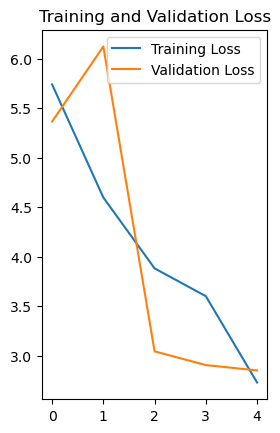

In [91]:
display_preds(ds,5)
display_losses(history,epochs)

1/1 [==============================] - 0s 85ms/step
Dif: [ 0.00996017 -0.01863867  0.02236201 -0.01365881 -0.02924718  0.01539753
  0.06695875 -0.01588392 -0.00947227  0.00747674]
1/1 [==============================] - 0s 96ms/step
Dif: [-0.01862212  0.03619014  0.0376606  -0.03483416 -0.03654289 -0.01208164
  0.05026302  0.05000662 -0.00296288 -0.0041603 ]
1/1 [==============================] - 0s 82ms/step
Dif: [-0.01245608 -0.01895399 -0.02096306  0.01303063 -0.01242281 -0.04018075
  0.03066715  0.00726708  0.00773212 -0.00492577]
1/1 [==============================] - 0s 80ms/step
Dif: [-0.08759098 -0.0384782  -0.05294217  0.00416889 -0.05784064 -0.01797457
 -0.01025855  0.08647054  0.04554454 -0.08615875]
1/1 [==============================] - 0s 81ms/step
Dif: [ 0.04501577 -0.01209857  0.01574582 -0.03211194 -0.06882581 -0.04325889
 -0.02741646  0.04758047  0.04772738  0.03458613]


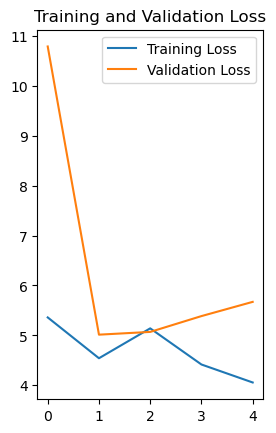

In [92]:
display_preds(mall_ds,5)
display_losses(mall_history,epochs)

In [99]:
model.save("model_v3")

2023-10-28 17:01:34.736397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,28,38,128]
	 [[{{node inputs}}]]
2023-10-28 17:01:34.879052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,28,38,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model_v3/assets


INFO:tensorflow:Assets written to: model_v3/assets


1/1 [==============================] - 0s 238ms/step
Prediction: 24.036401748657227 Actual: 24


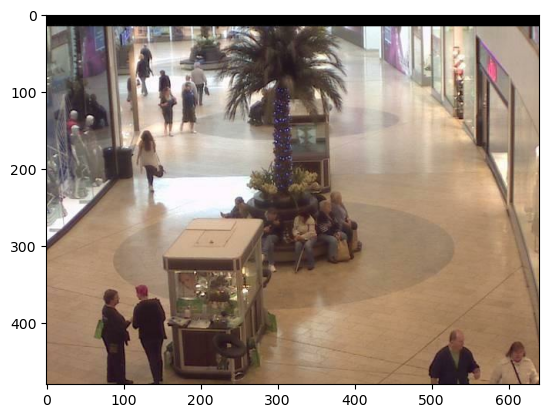

In [123]:
display_img_w_pred(model,mall_ds,10,8)

In [124]:
model.evaluate(sb_val_ds)

 3/80 [>.............................] - ETA: 3s - loss: 3.9175 - mean_squared_logarithmic_error: 0.0041

2023-10-28 18:05:58.142275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [400]
	 [[{{node Placeholder/_4}}]]
2023-10-28 18:05:58.142466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [400]
	 [[{{node Placeholder/_4}}]]


80/80 [==============================] - 4s 47ms/step - loss: 4.1303 - mean_squared_logarithmic_error: 0.0043


[4.130306720733643, 0.00430252542719245]

In [129]:
model.predict(ds[0][0])

1/1 [==============================] - 0s 198ms/step


array([[19.364393],
       [35.949955],
       [33.523697],
       [18.223652],
       [37.587128],
       [19.082012],
       [36.081875],
       [28.184746],
       [22.569435],
       [29.255465]], dtype=float32)

In [14]:
model = tf.keras.models.load_model("model")

In [18]:
ds2 = [x for x in make_ds(data_dir,labels,False,1).as_numpy_iterator()]

Found 2000 files belonging to 39 classes.
Using 1600 files for training.


2023-10-28 21:06:53.393710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-10-28 21:06:53.393908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-10-28 21:06:53.419603: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [20]:
model.predict(ds2[0][0])

1/1 [==============================] - 0s 119ms/step


array([[30.908407]], dtype=float32)